# Water Meters Detection

**Requirements:**
* Neural Network based model.
* There is GPU RTX2080 Ti used for data training. At test time, the algorithm should work without GPU.
*  Python and Pytorch are required in the experiment.

## Libraries import

In [ ]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torch
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Resize
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from tqdm import tqdm
import ast

## Configuration

In [ ]:
# TRAIN_MODE set to True if model already trained, False for inference
TRAIN_MODE = True

# Dataset Location
IMG_DIR_PATH = '../input/yandextoloka-water-meters-dataset/WaterMeters/images'
ANNOTATIONS_CSV_PATH = '../input/yandextoloka-water-meters-dataset/WaterMeters/data.csv'
MODEL_PATH = '' #### TODO: put the right path when TRAIN_MODE = False

#Resize SIZE
SIZE = 400

# PYTORCH parameters
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
BATCH_SIZE = 8
NB_EPOCHS = 8
NB_ITERATION = 1

## The dataset

**Dataset:** I used the following Kaggle repository: https://www.kaggle.com/tapakah68/yandextoloka-water-meters-dataset.


I created a customed image dataset following the PyTorch's guide https://pytorch.org/tutorials/beginner/basics/data_tutorial.html.

**Here,** we only one class of interest (the water meters), so we won't have to deal with multiclass dataset. There will be only 2 classes: 'background' and 'water_meter'. 

In [ ]:
#first create a dictionnary linking index to image name
# id values goes from 1 to 1244, I reframed that to have id from 0 to 1243.

INT_TO_NAME = {}
for dirname, _, filenames in os.walk(IMG_DIR_PATH):
    for filename in filenames:
        split = filename.split("_")
        INT_TO_NAME[int(split[1])-1] = filename
        
print('example: indice 2 file name -', INT_TO_NAME[1])
print('example: indice 1 file name -', INT_TO_NAME[0])


In [ ]:
location_test = pd.read_csv('../input/yandextoloka-water-meters-dataset/WaterMeters/data.csv').iloc[108,2]

def location_to_bounding_boxe(location, size):
    coordinate_list = ast.literal_eval(location)['data']
    x_s = [pt['x']*size for pt in coordinate_list]
    y_s = [pt['y']*size for pt in coordinate_list]
    return max(min(x_s),0), min(min(y_s),size),  max(max(x_s),0), min(size,max(y_s))
    
print("the location:", location_test)
print("---")
print("the corresponding bounding boxe",location_to_bounding_boxe(location_test, 460))

**Transformation :** I applied the normalization to stitch with the ResNet normalization on real-world images.

In [ ]:
transform_ = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.Resize([SIZE,SIZE]),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])#ResNet Normalization
    ])

class ImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform = None):
        self.img_labels = pd.read_csv(annotations_file).set_index('photo_name')
        self.img_dir = img_dir
        
        self.size = SIZE
        
        if transform:
            self.transform = transform


    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        name = INT_TO_NAME[idx]
        img_path = os.path.join(self.img_dir, name)
        image = read_image(img_path)
        reading = self.img_labels.loc[name, 'value']
        bounding_boxe =  location_to_bounding_boxe(self.img_labels.loc[name, 'location'], self.size)
        
        if self.transform:
            image = self.transform(image)
        
        return image, reading, torch.as_tensor(bounding_boxe, dtype=torch.float32)

In [ ]:
waterMeterDataset = ImageDataset(ANNOTATIONS_CSV_PATH, IMG_DIR_PATH, transform = transform_)

**Show images**

In [ ]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [ ]:
from torchvision.utils import draw_bounding_boxes
import torch
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F


plt.rcParams["savefig.bbox"] = 'tight'
plt.rcParams["figure.figsize"] = (20,80)

loader = DataLoader(waterMeterDataset, batch_size=8, shuffle=True)
img, _, bounding_boxes  = next(iter(loader))
img = (img.cpu()*255).type(torch.uint8)
images = [
    draw_bounding_boxes(image, boxes=boxe.unsqueeze(0), width=4)
    for image, boxe in zip(img, bounding_boxes)
]
show(images)

In [ ]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(waterMeterDataset), size=(1,)).item()
    img, reading, bounding_boxe = waterMeterDataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(reading)
    plt.axis("off")
    plt.imshow(img.squeeze().transpose(0,1).transpose(1,2), cmap="gray")
plt.show()

In [ ]:
train_size = int(0.9*len(waterMeterDataset))

## The model
I will keep it as simple as possible and use the Torchvision's implementation of Faster-RCNN with a pretrained ResNet-50-FPN backbone.

In [ ]:
def give_model():
    model = fasterrcnn_resnet50_fpn(pretrained=True, trainable_backbone_layers = 1)
    num_classes = 2  # 1 class (watermeter) + background
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model


## Evaluation

The dataset is really small (1244), I enriched it with a random color jitter but it is not huge enough to use a proper train-test-validation split. So I will only evaluate it with a random train/test split. 

In [ ]:
# adapted from https://debuggercafe.com/custom-object-detection-using-pytorch-faster-rcnn/
def train(train_dataloader, model, optimizer):
    print('Training')
    global train_itr
    global train_loss_list
    
     # initialize tqdm progress bar
    prog_bar = tqdm(train_dataloader, total=len(train_dataloader))
    
    for i, data in enumerate(prog_bar):
        optimizer.zero_grad()
        batch, _, bounding_boxes = data
        
        batch = list(image.to(DEVICE) for image in batch)
        
        #the faster R_CNN model takes as targets a list of dictionnary with boxe and label
        targets = [{'boxes': bounding_boxe.unsqueeze(0).to(DEVICE), 'labels': torch.ones(1, dtype = torch.int64).to(DEVICE)} for bounding_boxe in bounding_boxes]
        #it returns during training a dict containing the classification and regression losses.
        loss_dict = model(batch, targets)
        #print(loss_dict)
        losses = sum(loss for loss in loss_dict.values())
        
        loss_value = losses.item()
        
        train_loss_list.append(loss_value)
        
        losses.backward()
        optimizer.step()
        train_itr += 1
    
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
        
    return train_loss_list

def validate(test_dataloader, model):
    print('Validating')
    global val_itr
    global val_loss_list
    
    # initialize tqdm progress bar
    prog_bar = tqdm(test_dataloader, total=len(test_dataloader))
    
    for i, data in enumerate(prog_bar):
        batch, _, bounding_boxes = data
        
        batch = list(image.to(DEVICE) for image in batch)
        #the faster R_CNN model takes as targets a list of dictionnary with boxe and label
        targets = [{'boxes': bounding_boxe.unsqueeze(0).to(DEVICE), 'labels': torch.ones(1, dtype = torch.int64).to(DEVICE)} for bounding_boxe in bounding_boxes]
        
        with torch.no_grad():
            loss_dict = model(batch, targets)
        #it returns during training a dict containing the classification and regression losses.
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        
        val_loss_list.append(loss_value)
        val_itr += 1
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return val_loss_list


Loss: 0.1692: 100%|██████████| 16/16 [00:30<00:00,  1.90s/it]


Took 5.290 minutes for epoch 1

EPOCH 3 of 8
Training


Loss: 0.1677: 100%|██████████| 140/140 [04:45<00:00,  2.04s/it]


Validating


Loss: 0.1624: 100%|██████████| 16/16 [00:30<00:00,  1.89s/it]


Took 5.259 minutes for epoch 2

EPOCH 4 of 8
Training


Loss: 0.1889: 100%|██████████| 140/140 [04:46<00:00,  2.05s/it]


Validating


Loss: 0.1819: 100%|██████████| 16/16 [00:30<00:00,  1.91s/it]


Took 5.282 minutes for epoch 3

EPOCH 5 of 8
Training


Loss: 0.1663: 100%|██████████| 140/140 [04:46<00:00,  2.05s/it]


Validating


Loss: 0.1618: 100%|██████████| 16/16 [00:30<00:00,  1.90s/it]


Took 5.286 minutes for epoch 4

EPOCH 6 of 8
Training


Loss: 0.1595: 100%|██████████| 140/140 [04:46<00:00,  2.05s/it]


Validating


Loss: 0.1279: 100%|██████████| 16/16 [00:30<00:00,  1.93s/it]


Took 5.296 minutes for epoch 5

EPOCH 7 of 8
Training


Loss: 0.1712: 100%|██████████| 140/140 [04:46<00:00,  2.05s/it]


Validating


Loss: 0.1348: 100%|██████████| 16/16 [00:30<00:00,  1.91s/it]


Took 5.291 minutes for epoch 6

EPOCH 8 of 8
Training


Loss: 0.1987: 100%|██████████| 140/140 [04:46<00:00,  2.05s/it]


Validating


Loss: 0.1581: 100%|██████████| 16/16 [00:30<00:00,  1.91s/it]


Took 5.289 minutes for epoch 7
SAVING MODEL COMPLETE...



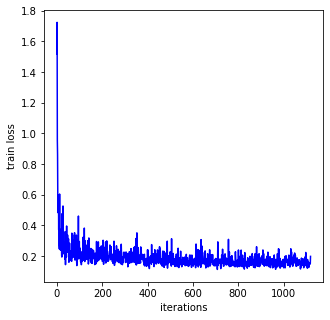

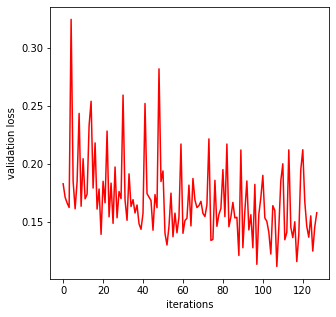

In [19]:
import time

plt.rcParams["figure.figsize"] = (5,5)

if TRAIN_MODE:
    train_set, val_set = torch.utils.data.random_split(waterMeterDataset, [train_size, len(waterMeterDataset) - train_size])
    train_dataloader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
    test_dataloader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True)

    model = give_model()
    model = model.to(DEVICE)

    params = [p for p in model.parameters() if p.requires_grad]

    # define the optimizer
    optimizer = torch.optim.SGD(params, lr=0.0001, momentum=0.8, weight_decay=0.0005)

    train_itr = 1
    val_itr = 1
    train_loss_list = []
    val_loss_list = []

    # name to save the trained model with
    MODEL_NAME = 'model'

    # create two subplots, one for each, training and validation
    figure_1, train_ax = plt.subplots()
    figure_2, valid_ax = plt.subplots()

    # start the training epochs
    for epoch in range(NB_EPOCHS):
        print(f"\nEPOCH {epoch+1} of {NB_EPOCHS}")

        # start timer and carry out training and validation
        start = time.time()

        train_loss = train(train_dataloader, model, optimizer)
        val_loss = validate(test_dataloader, model)

        end = time.time()
        print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch}")

    torch.save(model.state_dict(), "./"+ MODEL_NAME + ".pth")
    print('SAVING MODEL COMPLETE...\n')

    train_ax.plot(train_loss_list, color='blue')
    train_ax.set_xlabel('iterations')
    train_ax.set_ylabel('train loss')
    valid_ax.plot(val_loss_list, color='red')
    valid_ax.set_xlabel('iterations')
    valid_ax.set_ylabel('validation loss')
    plt.show()

## Inference

First, import the model or reuse the model used in training. Then I used two different methods to show the resulting bounding boxes.

In [20]:

import numpy as np
import cv2

if not TRAIN_MODE:
    model = model.load_state_dict(torch.load(MODEL_PATH, map_location=device))

model = model.to(DEVICE)
model.eval()
print('set model to evaluation mode')

set model to evaluation mode


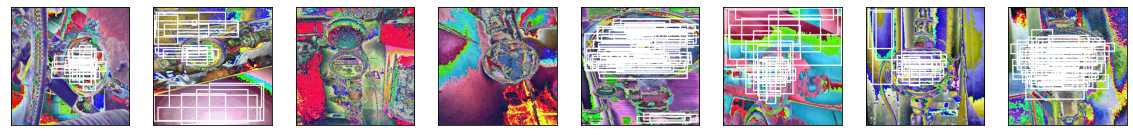

In [21]:
from torchvision.utils import draw_bounding_boxes
import torch
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F


plt.rcParams["savefig.bbox"] = 'tight'
plt.rcParams["figure.figsize"] = (20,80)

detection_threshold = 0.05


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

loader = DataLoader(waterMeterDataset, batch_size=8, shuffle=True)
img, _, bounding_boxes  = next(iter(loader))
img = img.to(DEVICE)

model.eval()
with torch.no_grad():
    outputs = model(img)

img = (img.cpu()*255).type(torch.uint8)
#images = img.cpu().data.numpy()
#load next operations to cpu
#outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]
images = [
    draw_bounding_boxes(image, boxes=output['boxes'][output['scores'] > detection_threshold], width=4)
    for image, output in zip(img, outputs)
]
show(images)